In [27]:
import numpy as np
import glob
import music21
import random
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Embedding, Bidirectional, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
import pickle
from keras.layers import GRU
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from music21 import stream, note, chord, instrument


In [2]:
SEQUENCE_LENGTH = 80
EPOCHS = 50
BATCH_SIZE = 64
GENERATED_LENGTH = 300
MIDI_PATH = "midi_files/*.mid"
OUTPUT_FILE = "local_files/generated.mid"

In [ ]:
# Data Preprocessing

def parse_midi_files(midi_path):
    """Extract notes & chords from MIDI files"""
    notes = []
    for file in glob.glob(midi_path):
        midi = music21.converter.parse(file)
        notes_to_parse = None

        try:
            s2 = music21.instrument.partitionByInstrument(midi)
            notes_to_parse = s2.parts[0].recurse()
        except:
            notes_to_parse = midi.flat.notes

        for element in notes_to_parse:
            if isinstance(element, music21.note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, music21.chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))
    return notes

notes = parse_midi_files(MIDI_PATH)
print(f"Total notes extracted: {len(notes)}")

Total notes extracted: 4993


In [29]:
# loading locally saved notes

# with open('local_files\input_notes.pkl', 'rb') as filepath:
#     notes = pickle.load(filepath)

In [ ]:
# # Saving notes for future use as a pickle file
# with open('midi_files/input_notes.pkl', 'wb') as filepath:
#     pickle.dump(notes, filepath)

In [6]:
# Mapping notes to integers
unique_notes = sorted(set(notes))
note_to_int = {note: i for i, note in enumerate(unique_notes)}
int_to_note = {i: note for i, note in enumerate(unique_notes)}


In [7]:
# Sequence preparation
network_input, network_output = [], []
for i in range(len(notes) - SEQUENCE_LENGTH):
    seq_in = notes[i:i+SEQUENCE_LENGTH]
    seq_out = notes[i+SEQUENCE_LENGTH]
    network_input.append([note_to_int[ch] for ch in seq_in])
    network_output.append(note_to_int[seq_out])

X = np.array(network_input)
y = to_categorical(network_output, num_classes=len(unique_notes))

print("Shape of Input:", X.shape)
print("Shape of Output:", y.shape)

Shape of Input: (4913, 80)
Shape of Output: (4913, 153)


In [16]:
#  Model building

model = Sequential([
    Embedding(len(unique_notes), 100, input_length=SEQUENCE_LENGTH),  # Embeddings for notes
    Bidirectional(GRU(256, return_sequences=True)),
    Dropout(0.3),
    BatchNormalization(),
    Bidirectional(GRU(256, return_sequences=True)),
    Dropout(0.3),
    BatchNormalization(),
    GRU(256),
    Dense(256, activation="relu"),
    Dropout(0.3),
    Dense(len(unique_notes), activation="softmax")
])

history = model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy", "top_k_categorical_accuracy"]
)


# Training with Callbacks

checkpoint = ModelCheckpoint(
    "best_model.h5",
    monitor="loss",
    save_best_only=True,
    mode="min"
)

early_stop = EarlyStopping(
    monitor="loss",
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="loss",
    factor=0.5,
    patience=5,
    verbose=1
)

history = model.fit(
    X, y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint, early_stop, reduce_lr]
)



c:\Users\ansul\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1326 - loss: 4.1913 - top_k_categorical_accuracy: 0.3162

77/77 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.1332 - loss: 4.1858 - top_k_categorical_accuracy: 0.3174 - learning_rate: 0.0010
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2678 - loss: 2.9525 - top_k_categorical_accuracy: 0.5863

77/77 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.2678 - loss: 2.9527 - top_k_categorical_accuracy: 0.5861 - learning_rate: 0.0010
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3311 - loss: 2.5882 - top_k_categorical_accuracy: 0.6649

77/77 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.3311 - loss: 2.5883 - top_k_categorical_accuracy: 0.6648 - learning_rate: 0.0010
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3938 - loss: 2.2897 - top_k_categorical_accuracy: 0.7261

77/77 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.3938 - loss: 2.2900 - top_k_categorical_accuracy: 0.7260 - learning_rate: 0.0010
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4434 - loss: 2.0145 - top_k_categorical_accuracy: 0.7841

77/77 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.4433 - loss: 2.0150 - top_k_categorical_accuracy: 0.7839 - learning_rate: 0.0010
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4765 - loss: 1.8964 - top_k_categorical_accuracy: 0.8070

77/77 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.4766 - loss: 1.8961 - top_k_categorical_accuracy: 0.8070 - learning_rate: 0.0010
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5399 - loss: 1.6292 - top_k_categorical_accuracy: 0.8487

77/77 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.5398 - loss: 1.6295 - top_k_categorical_accuracy: 0.8486 - learning_rate: 0.0010
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5715 - loss: 1.4564 - top_k_categorical_accuracy: 0.8777

77/77 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.5714 - loss: 1.4570 - top_k_categorical_accuracy: 0.8776 - learning_rate: 0.0010
Epoch 9/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6136 - loss: 1.3225 - top_k_categorical_accuracy: 0.9088

77/77 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.6135 - loss: 1.3227 - top_k_categorical_accuracy: 0.9086 - learning_rate: 0.0010
Epoch 10/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6662 - loss: 1.1454 - top_k_categorical_accuracy: 0.9374

77/77 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.6658 - loss: 1.1464 - top_k_categorical_accuracy: 0.9372 - learning_rate: 0.0010
Epoch 11/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6827 - loss: 1.0630 - top_k_categorical_accuracy: 0.9416

77/77 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.6824 - loss: 1.0637 - top_k_categorical_accuracy: 0.9416 - learning_rate: 0.0010
Epoch 12/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7178 - loss: 0.9290 - top_k_categorical_accuracy: 0.9632

77/77 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.7175 - loss: 0.9297 - top_k_categorical_accuracy: 0.9631 - learning_rate: 0.0010
Epoch 13/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7324 - loss: 0.8854 - top_k_categorical_accuracy: 0.9672

77/77 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.7322 - loss: 0.8858 - top_k_categorical_accuracy: 0.9672 - learning_rate: 0.0010
Epoch 14/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7487 - loss: 0.7865 - top_k_categorical_accuracy: 0.9791

77/77 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.7486 - loss: 0.7868 - top_k_categorical_accuracy: 0.9791 - learning_rate: 0.0010
Epoch 15/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7937 - loss: 0.6847 - top_k_categorical_accuracy: 0.9842

77/77 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.7935 - loss: 0.6854 - top_k_categorical_accuracy: 0.9842 - learning_rate: 0.0010
Epoch 16/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8161 - loss: 0.6197 - top_k_categorical_accuracy: 0.9885

77/77 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.8159 - loss: 0.6200 - top_k_categorical_accuracy: 0.9885 - learning_rate: 0.0010
Epoch 17/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8316 - loss: 0.5507 - top_k_categorical_accuracy: 0.9874

77/77 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.8314 - loss: 0.5511 - top_k_categorical_accuracy: 0.9874 - learning_rate: 0.0010
Epoch 18/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8544 - loss: 0.4965 - top_k_categorical_accuracy: 0.9918

77/77 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.8542 - loss: 0.4971 - top_k_categorical_accuracy: 0.9918 - learning_rate: 0.0010
Epoch 19/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8570 - loss: 0.4737 - top_k_categorical_accuracy: 0.9947

77/77 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.8568 - loss: 0.4742 - top_k_categorical_accuracy: 0.9947 - learning_rate: 0.0010
Epoch 20/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8614 - loss: 0.4338 - top_k_categorical_accuracy: 0.9941

77/77 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.8613 - loss: 0.4341 - top_k_categorical_accuracy: 0.9941 - learning_rate: 0.0010
Epoch 21/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8784 - loss: 0.4125 - top_k_categorical_accuracy: 0.9949

77/77 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.8782 - loss: 0.4129 - top_k_categorical_accuracy: 0.9948 - learning_rate: 0.0010
Epoch 22/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8871 - loss: 0.3819 - top_k_categorical_accuracy: 0.9974

77/77 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.8870 - loss: 0.3823 - top_k_categorical_accuracy: 0.9974 - learning_rate: 0.0010
Epoch 23/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8851 - loss: 0.3679 - top_k_categorical_accuracy: 0.9970

77/77 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.8850 - loss: 0.3682 - top_k_categorical_accuracy: 0.9970 - learning_rate: 0.0010
Epoch 24/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9012 - loss: 0.3274 - top_k_categorical_accuracy: 0.9965

77/77 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.9012 - loss: 0.3277 - top_k_categorical_accuracy: 0.9965 - learning_rate: 0.0010
Epoch 25/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9051 - loss: 0.3071 - top_k_categorical_accuracy: 0.9982

77/77 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.9050 - loss: 0.3076 - top_k_categorical_accuracy: 0.9982 - learning_rate: 0.0010
Epoch 26/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9031 - loss: 0.3122 - top_k_categorical_accuracy: 0.9971

77/77 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.9030 - loss: 0.3126 - top_k_categorical_accuracy: 0.9971 - learning_rate: 0.0010
Epoch 27/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9025 - loss: 0.3067 - top_k_categorical_accuracy: 0.9992

77/77 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.9024 - loss: 0.3070 - top_k_categorical_accuracy: 0.9992 - learning_rate: 0.0010
Epoch 28/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9076 - loss: 0.2864 - top_k_categorical_accuracy: 0.9990

77/77 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.9075 - loss: 0.2866 - top_k_categorical_accuracy: 0.9990 - learning_rate: 0.0010
Epoch 29/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9183 - loss: 0.2706 - top_k_categorical_accuracy: 0.9986

77/77 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.9182 - loss: 0.2708 - top_k_categorical_accuracy: 0.9986 - learning_rate: 0.0010
Epoch 30/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9172 - loss: 0.2535 - top_k_categorical_accuracy: 0.9981

77/77 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.9171 - loss: 0.2535 - top_k_categorical_accuracy: 0.9981 - learning_rate: 0.0010
Epoch 31/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9335 - loss: 0.2172 - top_k_categorical_accuracy: 0.9981

77/77 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.9333 - loss: 0.2176 - top_k_categorical_accuracy: 0.9980 - learning_rate: 0.0010
Epoch 32/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.9274 - loss: 0.2471 - top_k_categorical_accuracy: 0.9987 - learning_rate: 0.0010
Epoch 33/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.9210 - loss: 0.2517 - top_k_categorical_accuracy: 0.9988 - learning_rate: 0.0010
Epoch 34/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9250 - loss: 0.2365 - top_k_categorical_accuracy: 0.9984

77/77 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.9249 - loss: 0.2366 - top_k_categorical_accuracy: 0.9984 - learning_rate: 0.0010
Epoch 35/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9331 - loss: 0.2066 - top_k_categorical_accuracy: 0.9995

77/77 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.9331 - loss: 0.2069 - top_k_categorical_accuracy: 0.9995 - learning_rate: 0.0010
Epoch 36/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.9249 - loss: 0.2335 - top_k_categorical_accuracy: 0.9974 - learning_rate: 0.0010
Epoch 37/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.9307 - loss: 0.2167 - top_k_categorical_accuracy: 0.9990 - learning_rate: 0.0010
Epoch 38/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9373 - loss: 0.2077 - top_k_categorical_accuracy: 0.9985

77/77 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.9373 - loss: 0.2078 - top_k_categorical_accuracy: 0.9985 - learning_rate: 0.0010
Epoch 39/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.9320 - loss: 0.2064 - top_k_categorical_accuracy: 0.9993 - learning_rate: 0.0010
Epoch 40/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.9290 - loss: 0.2266 - top_k_categorical_accuracy: 0.9978 - learning_rate: 0.0010
Epoch 41/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.9331 - loss: 0.2137 - top_k_categorical_accuracy: 0.9994 - learning_rate: 0.0010
Epoch 42/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9401 - loss: 0.1945 - top_k_categorical_accuracy: 0.9964

77/77 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.9400 - loss: 0.1945 - top_k_categorical_accuracy: 0.9965 - learning_rate: 0.0010
Epoch 43/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9488 - loss: 0.1709 - top_k_categorical_accuracy: 0.9990

77/77 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.9487 - loss: 0.1712 - top_k_categorical_accuracy: 0.9990 - learning_rate: 0.0010
Epoch 44/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.9406 - loss: 0.1914 - top_k_categorical_accuracy: 0.9991 - learning_rate: 0.0010
Epoch 45/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.9406 - loss: 0.1768 - top_k_categorical_accuracy: 0.9992 - learning_rate: 0.0010
Epoch 46/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.9381 - loss: 0.1910 - top_k_categorical_accuracy: 0.9992 - learning_rate: 0.0010
Epoch 47/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.9310 - loss: 0.1899 - top_k_categorical_accuracy: 0.9994 - learning_rate: 0.0010
Epoch 48/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9408 - loss: 0.1965 - top_k_categorical_accuracy: 0.9988
Epoch 48: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
77/77 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.9407 - loss: 0.1967 - top

77/77 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.9551 - loss: 0.1420 - top_k_categorical_accuracy: 0.9998 - learning_rate: 5.0000e-04
Epoch 50/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9679 - loss: 0.1055 - top_k_categorical_accuracy: 0.9999

77/77 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.9679 - loss: 0.1055 - top_k_categorical_accuracy: 0.9999 - learning_rate: 5.0000e-04


In [ ]:
# # saving the model
# model.save('local_files/music_model_2.keras')

In [19]:
# # loading locally saved model using keras

# model = load_model('local_files\music_model.h5')


In [21]:
# Model evaluation
loss, acc, top5 = model.evaluate(X, y, verbose=0)
print(f"Final Loss: {loss:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"Top-5 Accuracy: {top5:.4f}")

Final Loss: 0.0255
Accuracy: 0.9902
Top-5 Accuracy: 1.0000


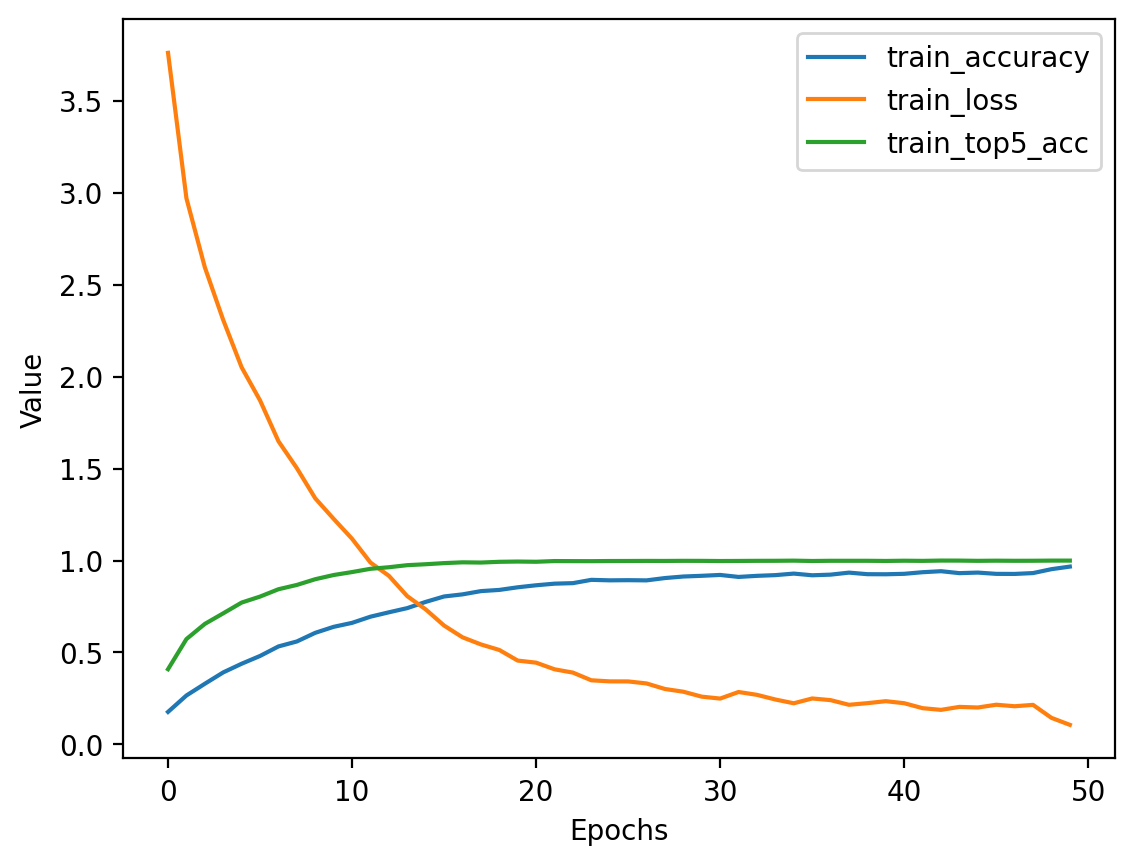

In [25]:
# plotting training metrics with repect to epochs
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['top_k_categorical_accuracy'], label='train_top5_acc')
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:

# Advanced Music Generation with temperature sampling
def sample_with_temperature(preds, temperature=1.0):
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds + 1e-8) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# generating notes using trained model
def generate_notes(model, seed, length=200, temperature=1.0):

    generated = []
    pattern = seed.copy()

    for i in range(length):
        prediction_input = np.array(pattern).reshape(1, -1)
        prediction = model.predict(prediction_input, verbose=0)[0]
        index = sample_with_temperature(prediction, temperature)
        result = int_to_note[index]
        generated.append(result)
        pattern.append(index)
        pattern = pattern[1:]
    return generated

# Pick a random seed
start_index = np.random.randint(0, len(X)-1)
seed = network_input[start_index]
generated_notes = generate_notes(model, seed, length=GENERATED_LENGTH, temperature=0.8)


[75, 152, 113, 33, 75, 58, 75, 88, 75, 152, 114, 104, 75, 93, 75, 150, 75, 138, 128, 75, 130, 118, 75, 113, 75, 120, 103, 113, 75, 103, 75, 92, 75, 151, 149, 137, 75, 127, 75, 117, 75, 115, 112, 112, 75, 102, 75, 91, 75, 130, 148, 136, 75, 126, 75, 116, 75, 0, 33, 75, 58, 75, 88, 75, 152, 113, 33, 75, 58, 75, 88, 75, 152, 114, 104, 75, 93, 75, 150, 75]


In [28]:
# Convert back to MIDI


offset = 0
output_notes = []

for pattern in generated_notes:
    if '.' in pattern:  # chord
        notes_in_chord = pattern.split('.')
        chord_notes = []
        for n in notes_in_chord:
            try:
                # Convert pitch class to note name (C=0, C#=1, ..., B=11)
                pitch_class = int(n)
                note_name = music21.pitch.Pitch(pitch_class).name
                chord_note = note.Note(note_name + '4')  # default octave 4
            except Exception:
                chord_note = note.Note('C4')  # fallback to C4 if conversion fails
            chord_note.storedInstrument = instrument.Piano()
            chord_notes.append(chord_note)
        new_chord = chord.Chord(chord_notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    else:  # single note
        try:
            # Try to interpret as pitch class
            pitch_class = int(pattern)
            note_name = music21.pitch.Pitch(pitch_class).name
            new_note = note.Note(note_name + '4')
        except Exception:
            # If not an integer, try as note name directly
            try:
                new_note = note.Note(pattern)
            except Exception:
                new_note = note.Note('C4')
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)
    offset += 0.5

midi_stream = stream.Stream(output_notes)
midi_stream.write("midi", fp=OUTPUT_FILE)

print(f" Generated music saved to {OUTPUT_FILE}")

 Generated music saved to local_files/generated.mid
